In [1]:
import time
import glob, os, os.path
import h5py
import numpy as np

import matplotlib.pylab as plt

import os
os.environ['KERAS_BACKEND'] = 'theano'

%matplotlib inline
from keras.utils.np_utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.callbacks import ModelCheckpoint
from keras.optimizers import adam
from keras.models import Model

pathFiles = "/home/atilla/Documents/DeepLearning/Test/"
os.chdir(pathFiles)




Using Theano backend.


In [2]:
file_name = 'V2_'
detail = 'compact_rand_norm_cate'
files = [file for file in glob.glob("*.hdf5") if file_name+detail in file]
f = h5py.File(files[0])
dataset_x = f['data_x'][...]
dataset_y = f['data_y'][...]
print (dataset_x.shape, dataset_y.shape, len(dataset_x))



# 2 Divide into train, test, validate

length = len(dataset_x)
length_train = int(round(0.8*length))
length_test = int(round(0.2*length))
#length_valid = int(round(0.2*length))
print(length_train, length_test)

train_data_x = dataset_x[0:length_train]
train_data_y = dataset_y[0: length_train]
test_data_x = dataset_x[length_train: length_train+length_test+1]
test_data_y = dataset_y[length_train: length_train+length_test+1]
# valid_data_x = dataset_x[length_train+length_test:length_train+length_test+ length_valid+1]
# valid_data_y = dataset_y[length_train+length_test:length_train+length_test+ length_valid+1]

print(test_data_x.shape, train_data_x.shape)#, valid_data_x.shape)

# 3. Import libraries and modules
import numpy as np
np.random.seed(123)  # for reproducibility





(625, 2, 30, 360) (625, 361) 625
500 125
(125, 2, 30, 360) (500, 2, 30, 360)


In [17]:
train_data_x_t = np.transpose (train_data_x, [0,2,3,1])
#train_data_y_t = np.transpose(train_data_y, [1,0])
test_data_x_t = np.transpose (test_data_x, [0,2,3,1])
#test_data_y_t = np.transpose(test_data_y, [1,0])


In [4]:
print(train_data_x_t.shape, train_data_y_t.shape)

(2, 30, 360, 500) (361, 500)


(30, 360)


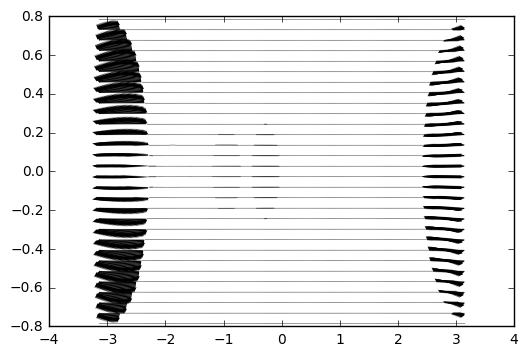

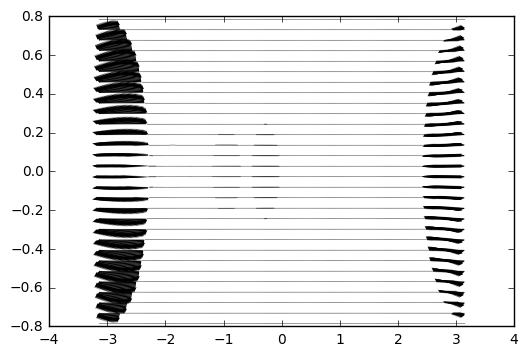

In [5]:
fov_x  = np.pi #half FOV along azimuth in radians
fov_y = np.pi/4 # half FOV along elevation in radians
res_x = 360 #amount of pixels along azimuth
res_y = 30 # amount of pixels along elevation

phis   = np.linspace(-fov_x, fov_x, res_x)
thetas = np.linspace(-fov_y, fov_y, res_y)

layout = np.array([[phi, theta] 
                   for theta in thetas
                   for phi in phis])
plt.figure()
ofx = train_data_x[40][0]
ofy = train_data_x[40][1]
plt.quiver(layout[:,0], layout[:,1], 
           ofx, ofy)
plt.figure()
ofx = train_data_x_t[0,:,:,40]
ofy = train_data_x_t[1,:,:,40]
plt.quiver(layout[:,0], layout[:,1], 
           ofx, ofy)
print(ofx.shape)

(5,)


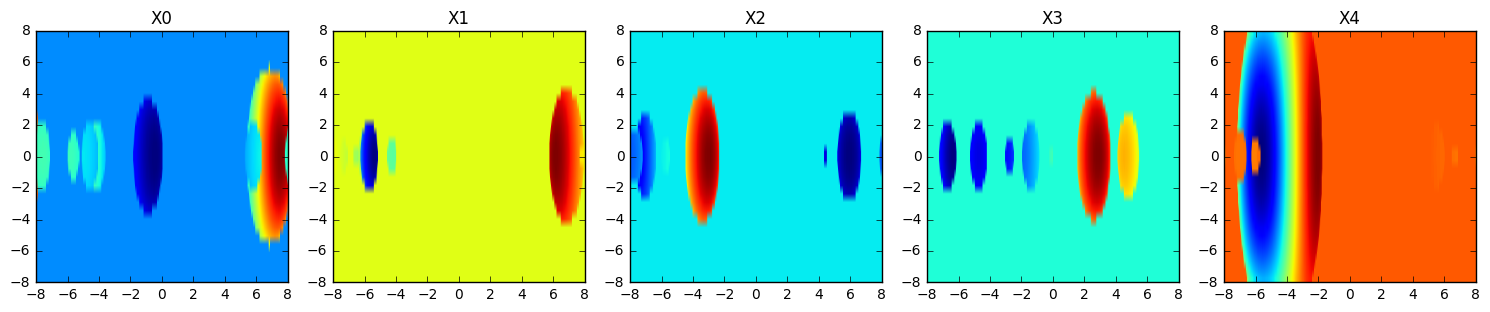

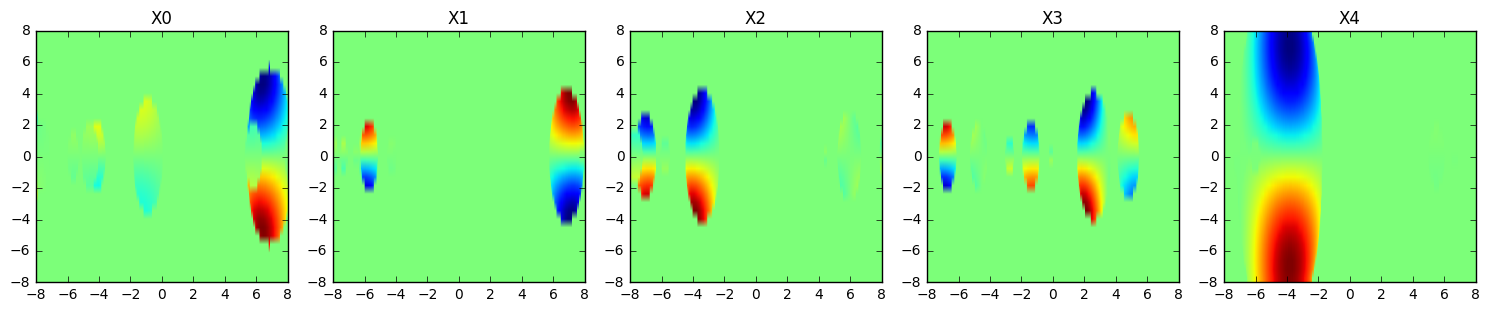

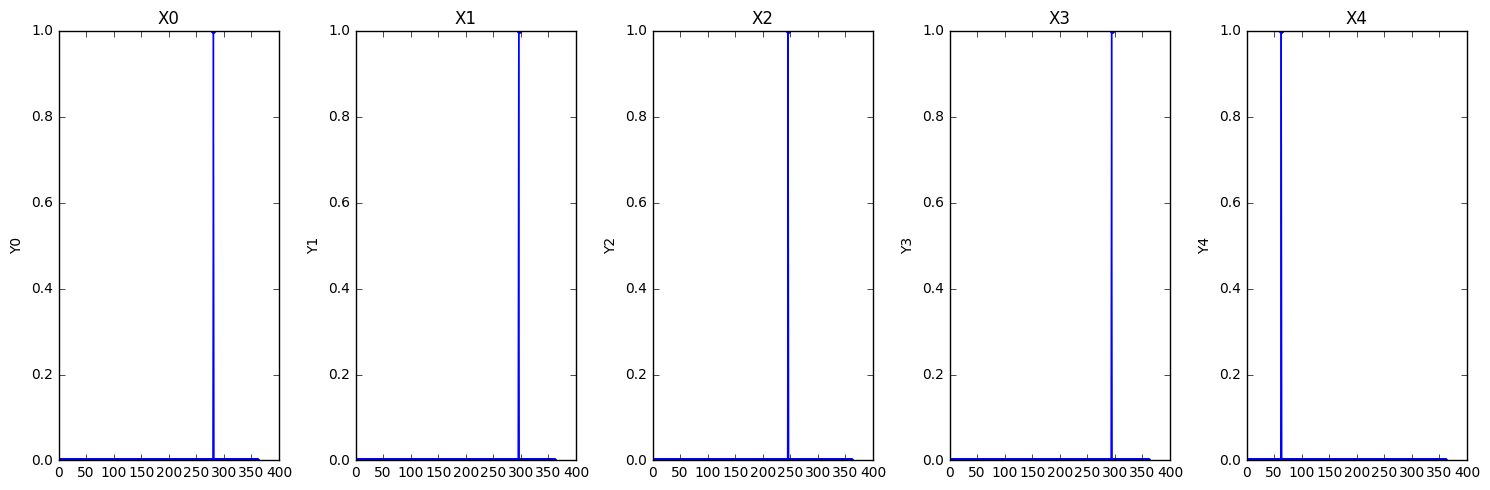

In [6]:
# Display some input
fig, axarr = plt.subplots(figsize=[15, 5],
                          nrows=1, ncols=5,
                          sharex='col')
print(axarr.shape)
for i in range(axarr.shape[0]):
    ax = axarr[i]
    ofx = train_data_x[i][0]
    ofy = train_data_x[i][1]
#     ax.quiver(layout[:,0], layout[:,1], 
#            ofx, ofy)
    ax.imshow(ofx, extent =[-8,8,-8,8], origin='lower')
    ax.set_title('X' + str(i))    
fig.tight_layout()

fig, axarr = plt.subplots(figsize=[15, 5],
                          nrows=1, ncols=5,
                          sharex='col')
for i in range(axarr.shape[0]):
    ax = axarr[i]
    ofx = train_data_x[i][0]
    ofy = train_data_x[i][1]
    of = train_data_x [i]
#     ax.quiver(layout[:,0], layout[:,1], 
#            ofx, ofy)
    ax.imshow(ofy, extent =[-8,8,-8,8])
    ax.set_title('X' + str(i))    
fig.tight_layout()

fig, axarr = plt.subplots(figsize=[15, 5],
                          nrows=1, ncols=5,
                          sharex='col')
for i in range(axarr.shape[0]):
    ax = axarr[i]
    ax.set_title('X' + str(i))
   # ax.set_ylim(0, 30)
    ax.plot(train_data_y[i], '.-')
    #ax = axarr[1, i]
#     ax.plot(Y_train[i], '.-')
    ax.set_ylabel('Y' + str(i))
   # ax.set_xlim(0, 360)
    
fig.tight_layout()


In [7]:
batch_size = 12
num_classes = 1
epochs = 5

# x and y dimensions of input images
shapex, shapey = 360, 30
# number of convolutional filters to use
num_filters = 32
# side length of maxpooling square
num_pool = 2
# side length of convolution square
num_conv = 3


In [8]:

# # 7. Define model architecture
# model = Sequential()
# model.add(ZeroPadding2D((1,1),input_shape=(2,30,360), dim_ordering = 'th'))
# model.add(Convolution2D(16, 3, 3,dim_ordering = 'th', activation='relu'))#, input_shape=(2,30,360)))
# model.add(ZeroPadding2D((1,1), dim_ordering = 'th'))
# model.add(Convolution2D(32, 3, 3,dim_ordering = 'th', activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))

# model.add(ZeroPadding2D((1,1), dim_ordering = 'th'))
# model.add(Convolution2D(32, 3, 3, dim_ordering= 'th', activation='relu'))
# model.add(ZeroPadding2D((1,1), dim_ordering = 'th'))
# model.add(Convolution2D(64, 3, 3, dim_ordering = 'th', activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))

# # model.add(ZeroPadding2D((1,1), dim_ordering = 'th'))
# # model.add(Convolution2D(64, 3, 3, dim_ordering= 'th', activation='relu'))
# # model.add(ZeroPadding2D((1,1), dim_ordering = 'th'))
# # model.add(Convolution2D(128, 3, 3, dim_ordering = 'th', activation='relu'))
# # model.add(MaxPooling2D((2,2), strides=(2,2)))


# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(361, activation='softmax'))



# # model.add(Convolution2D(32, 3, 3, activation='relu'))
# # model.add(MaxPooling2D(pool_size=(2,2)))
# # model.add(Dropout(0.25))
# # model.add(Flatten())
# # model.add(Dense(30, activation='relu'))
# # model.add(Dropout(0.5))
# # model.add(Dense(1, activation='softmax'))
# # 8. Compile model
# # model.compile(loss='_crossentropy',
# #               optimizer='adam',
# #               metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-4), metrics=['accuracy'])
# #model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# model.summary()



In [9]:
# from keras import backend as K

# # this is a placeholder tensor that will contain our generated images
# first_layer = model.layers[0]
# input_img = first_layer.input

In [10]:

# # 8.2 Save model 

# checkpointer = ModelCheckpoint(filepath = "/home/atilla/Documents/DeepLearning/Test/weights.hdf5", verbose = 1, save_best_only = True)

# # 9. Fit model on training data
# model.fit(train_data_x, train_data_y,
#           batch_size=10, nb_epoch=epochs, verbose=1, validation_split = 0.2,  callbacks =[checkpointer] )

# # 10. Evaluate model on test data
# score = model.evaluate(test_data_x, test_data_y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# model.save('/home/atilla/Documents/DeepLearning/Test/model1.hdf5')

In [11]:

# # 8.2 Save model 

# checkpointer = ModelCheckpoint(filepath = "/home/ajv/Desktop/DroneAI/weights.hdf5", verbose = 1, save_best_only = True)

# # 9. Fit model on training data
# model.fit(train_data_x, train_data_y,
#           batch_size=10, nb_epoch=epochs, verbose=1, validation_split = 0.2,  callbacks =[checkpointer] )

# # 10. Evaluate model on test data
# score = model.evaluate(test_data_x, test_data_y, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

# model.save('/home/ajv/Desktop/DroneAI/model1.hdf5')

# Visualize what the model predicts

What can be observed, is that the model will spit out a vector with a lot of values. Will be interesting to see how close it gets when the model is better trained.



# New way of representing model 
using keras.models instead

In [15]:
from keras.layers import Input, Dense, Flatten, Activation
from keras.models import Model

Bottom_dense=True
# 7. Define model architecture
#model = Sequential()
inputs = Input(shape =(30,360,2), name = 'main_input' )
x =ZeroPadding2D((1,1), name ='zero_1') (inputs)
x = Convolution2D(16, 3, 3, activation='relu', name = 'conv_1')(x)
x =ZeroPadding2D((1,1),  name = 'zero_2')(x)
x =Convolution2D(32, 3, 3, activation='relu', name = 'conv_2')(x)
x= MaxPooling2D((2,2), strides=(2,2), name = 'max_1')(x)
x =ZeroPadding2D((1,1), name= 'zero_3')(x)
x= Convolution2D(32, 3, 3, activation='relu', name = 'conv_3')(x)
x= ZeroPadding2D((1,1),  name = 'zero_4')(x)
x=Convolution2D(64, 3, 3, activation='relu', name = 'conv_4')(x)
x=MaxPooling2D((2,2), strides=(2,2), name= 'max_2')(x)



# inputs = Input(shape =(2,30,360), name = 'main_input' )
# x =ZeroPadding2D((1,1), dim_ordering = 'th', name ='zero_1') (inputs)
# x = Convolution2D(16, 3, 3,dim_ordering = 'th', activation='relu', name = 'conv_1')(x)
# x =ZeroPadding2D((1,1), dim_ordering = 'th', name = 'zero_2')(x)
# x =Convolution2D(32, 3, 3,dim_ordering = 'th', activation='relu', name = 'conv_2')(x)
# x= MaxPooling2D((2,2), strides=(2,2), dim_ordering = 'th', name = 'max_1')(x)
# x =ZeroPadding2D((1,1), dim_ordering = 'th', name= 'zero_3')(x)
# x= Convolution2D(32, 3, 3, dim_ordering= 'th', activation='relu', name = 'conv_3')(x)
# x= ZeroPadding2D((1,1), dim_ordering = 'th', name = 'zero_4')(x)
# x=Convolution2D(64, 3, 3, dim_ordering = 'th', activation='relu', name = 'conv_4')(x)
# x=MaxPooling2D((2,2), strides=(2,2), dim_ordering = 'th', name= 'max_2')(x)

# model.add(ZeroPadding2D((1,1), dim_ordering = 'th'))
# model.add(Convolution2D(64, 3, 3, dim_ordering= 'th', activation='relu'))
# model.add(ZeroPadding2D((1,1), dim_ordering = 'th'))
# model.add(Convolution2D(128, 3, 3, dim_ordering = 'th', activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))


x =Flatten(name = 'flatten_1')(x)
if Bottom_dense == True :
    x =Dense(128, activation='relu', name = 'dense_1')(x)
    x=Dropout(0.5, name = 'drop_1')(x)
    x = Dense(128, activation='relu', name = 'dense_2')(x)
    x = Dropout(0.5, name = 'drop_2')(x)
    x=Dense(361, activation='softmax', name = 'dense_3')(x)
#     x=Dense(361, name = 'dense_3')(x)
#     x= Activation ('softmax',name = 'activation')(x)

model = Model(inputs, x, name= 'simple_model')

# model.add(Convolution2D(32, 3, 3, activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='softmax'))
# 8. Compile model
# model.compile(loss='_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer=adam(lr=1e-4), metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.summary()


(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 30, 360, 2)    0                                            
____________________________________________________________________________________________________
zero_1 (ZeroPadding2D)           (None, 32, 362, 2)    0           main_input[0][0]                 
____________________________________________________________________________________________________
conv_1

# Train/save model and weights

In [18]:

# 8.2 Save model 

checkpointer = ModelCheckpoint(filepath = "/home/atilla/Documents/DeepLearning/Test/weights4.hdf5", verbose = 1, save_best_only = True)

# 9. Fit model on training data
model.fit(train_data_x_t, train_data_y,
          batch_size=10, nb_epoch=epochs, verbose=1, validation_split = 0.2,  callbacks =[checkpointer] )
model.save_weights("/home/atilla/Documents/DeepLearning/Test/weights4_3.hdf5")
# 10. Evaluate model on test data
score = model.evaluate(test_data_x_t, test_data_y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

model.save('/home/atilla/Documents/DeepLearning/Test/model4.hdf5')

Train on 400 samples, validate on 100 samples
Epoch 1/5
400/400 [==============================] - 33s - loss: 5.8728 - acc: 0.0025 - val_loss: 5.8074 - val_acc: 0.0300
Epoch 2/5
400/400 [==============================] - 33s - loss: 5.7277 - acc: 0.0100 - val_loss: 5.6034 - val_acc: 0.0600
Epoch 3/5
400/400 [==============================] - 31s - loss: 5.4925 - acc: 0.0150 - val_loss: 5.3043 - val_acc: 0.1100
Epoch 4/5
400/400 [==============================] - 32s - loss: 5.1285 - acc: 0.0350 - val_loss: 4.9301 - val_acc: 0.1300
Epoch 5/5
400/400 [==============================] - 31s - loss: 4.9224 - acc: 0.0450 - val_loss: 4.6422 - val_acc: 0.1600
acc: 19.20%


Load Model

In [19]:
from keras.models import load_model
model2 = load_model('/home/atilla/Documents/DeepLearning/Test/model4.hdf5')
model2.summary()
#model.load_weights('/home/atilla/Documents/DeepLearning/Test/weights.hdf5')

(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (None, 30, 360, 2)    0                                            
____________________________________________________________________________________________________
zero_1 (ZeroPadding2D)           (None, 32, 362, 2)    0           main_input[0][0]                 
____________________________________________________________________________________________________
conv_1

(500, 2, 30, 360)


[]

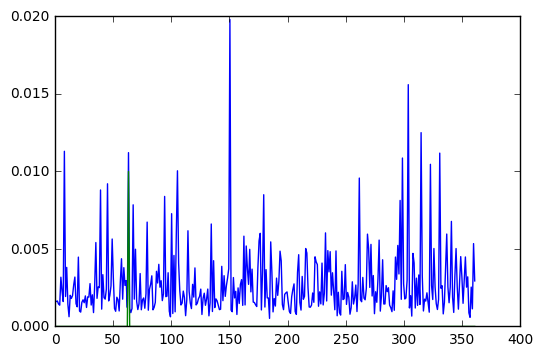

In [21]:
y = model2.predict(train_data_x_t)
print(train_data_x.shape)
y1 = train_data_y[0:5] 
t = np.linspace(0,361, 361, endpoint = True)
plt.plot(t,y[4], t, y1[4]/100)
plt.plot()

In [ ]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])
for i, layername in enumerate(layer_dict):
    print(i, layername)

# names = model2.get_layer('dense_3')
# print(names)

In [ ]:
from keras import backend as K

# this is a placeholder tensor that will contain our generated images
#first_layer = model.layers[0]
# input_img =model.input
# (type(input_img))

first_layer = model.layers[0]
input_img = first_layer.input
type(input_img)

In [ ]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
from scipy.misc import imsave
# build a loss function that maximizes the activation
layer_name = 'conv_2'
layer_output = layer_dict[layer_name].output

# fig, axarr = plt.subplots(figsize=[15, 5],
#                           ncols=5)
fig, axarr = plt.subplots(figsize=[15, 20],
                          nrows=2, ncols=4)

for output_index in range(8):
    print()
#     filter_index = 2 # can be any integer from 0 to 511, as there are 512 filters in that layer
    # of the nth filter of the layer considered
    # layer_output = layer_dict[layer_name].output
#     loss = K.mean(layer_output[:, output_index, :, :])
    loss = K.mean(layer_output[:, output_index])
#   loss = K.mean(layer_output[:, output_index, :, :])
    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # we start from a gray image with some noise
    # input_img_data = np.zeros((1, 28, 28)) 
    input_img_data = np.random.random((1,2, 30, 360)) * 0.5
    step = 1.0
    # run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        if i %5 == 0:
            print(loss_value, end =', ')
    #print(input_img_data.shape)
    img = input_img_data[0]
    img_rgb =np.transpose(np.vstack([img,np.zeros([1,img.shape[1], img.shape[2]])]),[1,2,0])
    ax = axarr[output_index//4, output_index%4]
    ax.imshow(img_rgb, aspect = 'auto')
    ax.set_title('Input OF ' + str(output_index))
    #imsave('/home/atilla/Documents/DeepLearning/Automate/test2_2/%s_filter_%d.png' % (layer_name, output_index), img_rgb)
fig.tight_layout()
    

    #img = deprocess_image(img)
    #fig, axarr = plt.subplots(figsize=[15, 5],
    #                            ncols=6)
#     ax = axarr[output_index]
#     ax.imshow(img, aspect = 'auto')
    #plt.imshow(img[1],  aspect='auto')
    #     ax = axarr[output_index]
    #     ax.imshow(img)
    #     ax.set_title('Filter ' + str(output_index))

In [ ]:
# a=np.zeros([1,img.shape[1], img.shape[2]])
# print(a.shape, img.shape)
#img_rgb =np.transpose(np.vstack([img,np.zeros([1,img.shape[1], img.shape[2]])]),[1,2,0])
plt.imshow(img_rgb, aspect = 'auto')

# ax = axarr[output_index]
# ax.imshow(img, aspect = 'auto')